# Greater Sydney Analysis

## 1. Data Loading

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint
from geoalchemy2 import Geometry, WKTElement
import matplotlib.pyplot as plt

srid = 4326
credentials = "Credentials.json"

### PostgreSQL Connection

In [29]:
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        try:
            db = create_engine('postgresql+psycopg2://'+db_user+':'+db_pw+'@'+host+'/'+default_db, echo=False)
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

def query(conn, sqlcmd, args=None, df=True):
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(sqlcmd, args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

db, conn = pgconnect(credentials)
query(conn, "select PostGIS_Version()")

Connected successfully.


,postgis_version
0,3.3 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


### Master Imports

In [3]:
# SA2 Regions Data
regions_master = gpd.read_file("data/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")

# Businesses Data
businesses_master = pd.read_csv("data/Businesses.csv")

# Public Transport Stops Data
stops_master = pd.read_csv('data/Stops.txt')

# Polling Places Data
polls_master = pd.read_csv('data/PollingPlaces2019.csv')

# School cathchments data
catchments_primary = gpd.read_file("data/catchments/catchments_primary.shp")
catchments_secondary = gpd.read_file("data/catchments/catchments_secondary.shp")
catchments_future = gpd.read_file("data/catchments/catchments_future.shp")

# Population Data
population_master = pd.read_csv('data/Population.csv')

# Income Data
income_master = pd.read_csv('data/Income.csv', dtype={'sa2_code': str})


### Cleaning

In [4]:
# Multipolygon cleaning function
def create_wkt_element(geom, srid):
    if geom.geom_type == 'Polygon':
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

# Regions Cleaning
regions = regions_master.copy()[(regions_master.geometry != None) & (regions_master.GCC_NAME21 == "Greater Sydney")]
regions["geom"] = regions["geometry"].apply(lambda x: create_wkt_element(geom=x,srid=srid))
regions = regions[["SA2_CODE21", "SA2_NAME21", "geom"]].rename(columns = {"SA2_CODE21": "sa2_code", "SA2_NAME21": "sa2_name"})
regions["sa2_code"] = pd.to_numeric(regions["sa2_code"], errors="coerce")

# Businesses Cleaning
businesses = businesses_master[["industry_code", "industry_name", "sa2_code", "sa2_name", "total_businesses"]]
businesses = businesses.loc[businesses["sa2_code"].isin(regions["sa2_code"])]

# Stops Cleaning
stops = stops_master.copy()
stops["geom"] = gpd.points_from_xy(stops.stop_lon, stops.stop_lat)
stops["geom"] = stops["geom"].apply(lambda x: WKTElement(x.wkt, srid=srid))
stops = stops[["stop_id", "stop_name", "geom"]]
stops = stops.rename(columns={
    "stop_id": "id",
    "stop_name": "name"
})
stops["id"] = pd.to_numeric(stops["id"], errors="coerce")
stops = stops.dropna(subset=["id"])
stops = stops.drop_duplicates(subset=["id", "name"])

# Polls Cleaning
polls = polls_master.copy()
polls["geom"] = gpd.points_from_xy(polls.longitude, polls.latitude)
polls["geom"] = polls["geom"].apply(lambda x: WKTElement(x.wkt, srid=srid))
polls = polls[["polling_place_id", "polling_place_name", "geom"]]
polls = polls.rename(columns={
    "polling_place_id": "id",
    "polling_place_name": "name"
})

# Schools Cleaning
schools = pd.concat([catchments_primary, catchments_secondary, catchments_future], ignore_index = True)
schools['geom'] = schools['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 
schools = schools[['USE_ID', 'CATCH_TYPE','geom']].drop_duplicates()
schools = schools.rename(columns={
   'USE_ID': 'id',
   'CATCH_TYPE': 'type'
})
schools = schools.drop_duplicates(subset=["id", "type"])

# Population Cleaning
population = population_master.copy()
population['sa2_code'] = population['sa2_code'].astype(str)
population.columns = map(str.lower, population.columns)
if 'young_people' not in population.columns:
  population['young_people'] = population.iloc[:, 2:6].sum(axis=1)
population = population[['sa2_code', 'young_people', 'total_people']].drop_duplicates()
population["sa2_code"] = pd.to_numeric(population["sa2_code"], errors="coerce")
population = population.loc[population["sa2_code"].isin(regions["sa2_code"])]

# Income Cleaning
income = income_master.copy()
income.columns = map(str.lower, income.columns)
income = income[['sa2_code', 'median_income']]
income.drop(income[income['median_income']=='np'].index, inplace = True)
income['median_income'] = income['median_income'].astype(int)
income["sa2_code"] = pd.to_numeric(income["sa2_code"], errors="coerce")
income = income.loc[income["sa2_code"].isin(regions["sa2_code"])]

### Adding to Data to PostgreSQL

In [32]:
conn.execute("""
create schema if not exists sydney;
set search_path to sydney,public,postgis;
""")

# Regions Table
conn.execute("""
DROP TABLE IF EXISTS regions CASCADE;
CREATE TABLE regions (
    sa2_code INTEGER PRIMARY KEY, 
    sa2_name VARCHAR(100), 
    geom GEOMETRY(MULTIPOLYGON, {})
);""".format(srid)
)

# Businesses Table
conn.execute(
"""
DROP TABLE IF EXISTS businesses CASCADE;
CREATE TABLE businesses (
    industry_code CHAR(1),
    industry_name VARCHAR(100),
    sa2_code INTEGER,
    sa2_name VARCHAR(100),
    total_businesses INTEGER,
    PRIMARY KEY (industry_code, sa2_code),
    FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code)
);
"""
)
             
# Stops Table
conn.execute("""
DROP TABLE IF EXISTS stops CASCADE;
CREATE TABLE stops (
    id INTEGER PRIMARY KEY, 
    name VARCHAR(100),
    geom GEOMETRY(POINT, {})
);""".format(srid)
)

# Polling Places Table
conn.execute("""
DROP TABLE IF EXISTS polls CASCADE;
CREATE TABLE polls (
    id INTEGER PRIMARY KEY,
    name VARCHAR(100),
    geom GEOMETRY(POINT, {})
);""".format(srid)
)

# Schools Table
conn.execute("""
DROP TABLE IF EXISTS schools CASCADE;
CREATE TABLE schools (
    id INTEGER, 
    type VARCHAR(25), 
    geom GEOMETRY(MULTIPOLYGON, {}),
    PRIMARY KEY (id, type)
);""".format(srid)
)

# Population Table
conn.execute("""
DROP TABLE IF EXISTS population CASCADE;
CREATE TABLE population (
    sa2_code INTEGER PRIMARY KEY, 
    young_people INTEGER,
    total_people INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code)
);"""
)

# Income Table
conn.execute("""
DROP TABLE IF EXISTS income CASCADE;
CREATE TABLE income (
    sa2_code INTEGER PRIMARY KEY, 
    median_income INTEGER,
    FOREIGN KEY (sa2_code) REFERENCES regions(sa2_code)
);"""
)

regions.to_sql('regions', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
businesses.to_sql('businesses', conn, if_exists='append', index=False)
stops.to_sql('stops', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
polls.to_sql('polls', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINT', srid)})
schools.to_sql('schools', conn, if_exists='append', index=False, dtype={'geom': Geometry('MULTIPOLYGON', srid)})
population.to_sql('population', conn, if_exists='append', index=False)
income.to_sql('income', conn, if_exists='append', index=False)

256

#### Creating Indexes

In [6]:
conn.execute("""
DROP INDEX IF EXISTS regions_geom_idx;
CREATE INDEX regions_geom_idx
  ON regions USING GIST(geom);

DROP INDEX IF EXISTS regions_sa2_code_idx;
CREATE INDEX regions_sa2_code_idx
  ON regions(sa2_code);

DROP INDEX IF EXISTS stops_geom_idx;
CREATE INDEX stops_geom_idx
  ON stops USING GIST(geom);
""")

## 2. Scoring

#### Score Processing

In [33]:
conn.execute("""
Drop view if exists query_table cascade;

CREATE VIEW query_table AS (
    WITH
    n_retail as (
      SELECT sa2_code, SUM(total_businesses) as n_retail
      FROM regions
      LEFT JOIN businesses USING (sa2_code)
      WHERE lower(industry_name) LIKE '%%retail%%'
      GROUP BY sa2_code
    ),

    n_health as (
      SELECT sa2_code, SUM(total_businesses) as n_health
      FROM regions
      LEFT JOIN businesses USING (sa2_code)
      WHERE lower(industry_name) LIKE '%%health%%'
      GROUP BY sa2_code
    ),

    n_stops as (
        SELECT sa2_code, count(stops.id) as n_stops
        FROM regions
        LEFT JOIN stops ON (ST_Contains(regions.geom, stops.geom))
        GROUP BY sa2_code
    ),

    n_polls as (
        SELECT sa2_code, count(polls.id) as n_polls
        FROM regions
        LEFT JOIN polls ON (ST_Contains(regions.geom, polls.geom))
        GROUP BY sa2_code
    ),

    n_catchments as (
        SELECT sa2_code, count(schools.id) as n_catchments
        FROM regions
        LEFT JOIN schools ON ST_Intersects(regions.geom, schools.geom)
        GROUP BY sa2_code, sa2_name, regions.geom
    )

    SELECT *
    FROM regions
    LEFT JOIN n_retail USING (sa2_code)
    LEFT JOIN n_health USING (sa2_code)
    LEFT JOIN n_stops USING (sa2_code)
    LEFT JOIN n_polls USING (sa2_code)
    LEFT JOIN n_catchments USING (sa2_code)
    LEFT JOIN population USING (sa2_code)
    LEFT JOIN income USING (sa2_code)
    WHERE total_people >= 100
);

drop view if exists z_scores cascade;
CREATE VIEW z_scores AS (
    WITH 
    index_table AS (
      SELECT *, 
      n_retail::float / total_people::float / 1000.0 as retail_index,
      n_health::float / total_people::float / 1000.0 as health_index,
      n_catchments::float / young_people::float / 1000.0 as school_index,
      n_stops::float / ST_Area(geom) as stops_index,
      n_polls::float / ST_Area(geom) as polls_index
      FROM query_table
    ),

    retail_norm AS (
      SELECT AVG(retail_index) as mean,
            stddev(retail_index) as sd
      FROM index_table
    ),

    health_norm AS (
      SELECT AVG(health_index) as mean,
            stddev(health_index) as sd
      FROM index_table
    ),

    stops_norm AS (
      SELECT AVG(stops_index) as mean,
            stddev(stops_index) as sd
      FROM index_table
    ),

    polls_norm AS (
      SELECT AVG(polls_index) as mean,
            stddev(polls_index) as sd
      FROM index_table
    ),

    schools_norm AS (
      SELECT AVG(school_index) as mean,
            stddev(school_index) as sd
      FROM index_table)
        
    SELECT
        sa2_code, sa2_name, median_income, geom,
        (retail_index - retail_norm.mean) / retail_norm.sd AS z_retail,
        (health_index - health_norm.mean) / health_norm.sd AS z_health,
        (stops_index - stops_norm.mean) / stops_norm.sd AS z_stops,
        (polls_index - polls_norm.mean) / polls_norm.sd AS z_polls,
        (school_index - schools_norm.mean) / schools_norm.sd AS z_schools
    FROM retail_norm, health_norm, stops_norm, polls_norm, schools_norm, index_table
);
""")

conn.execute("""
  DROP VIEW IF EXISTS scores CASCADE;
    CREATE VIEW scores AS (
        WITH z_sum AS (
            SELECT z_scores.*,
                  (z_retail + z_health + z_stops + z_polls + z_schools) as z_sum
            FROM z_scores
        )

        SELECT sa2_code, sa2_name, median_income, geom,
              (1.0 / (1.0 + exp(-z_sum))) as score
        FROM z_sum
        ORDER BY score desc
    )
""")

#### Score Retrieval

In [8]:
scores_master = gpd.GeoDataFrame.from_postgis("SELECT * FROM scores", conn)
scores_master

,sa2_code,sa2_name,median_income,geom,score
0,117031644,Sydney (North) - Millers Point,NaN,"MULTIPOLYGON (((151.22538 -33.85525, 151.22525...",1.000000
1,117011320,Banksmeadow,68584.0,"MULTIPOLYGON (((151.20807 -33.95405, 151.20817...",1.000000
2,117031645,Sydney (South) - Haymarket,NaN,"MULTIPOLYGON (((151.19852 -33.87579, 151.19847...",1.000000
3,117031329,Darlinghurst,71676.0,"MULTIPOLYGON (((151.21227 -33.87631, 151.21232...",0.999972
4,119031664,Hurstville - Central,NaN,"MULTIPOLYGON (((151.10102 -33.96455, 151.10154...",0.999540
...,...,...,...,...,...
355,123031447,Picton - Tahmoor - Buxton,55890.0,"MULTIPOLYGON (((150.50758 -34.25908, 150.50120...",0.034575
356,102021050,Lake Munmorah - Mannering Park,46693.0,"MULTIPOLYGON (((151.56544 -33.16638, 151.56548...",0.034387
357,102021045,Blue Haven - San Remo,49191.0,"MULTIPOLYGON (((151.49030 -33.20791, 151.48825...",0.034081
358,124031707,Cranebrook - Castlereagh,NaN,"MULTIPOLYGON (((150.65869 -33.70214, 150.65871...",0.033873


## 3. Extending Score

#### Homelessness Data

In [34]:
homelessness_master = pd.read_excel('data/Homelessness.xlsx', dtype={'sa2_code': int})

# Cleaning
homelessness = homelessness_master.copy()
homelessness.columns = map(str.lower, homelessness.columns)
homelessness.dropna(inplace=True)
homelessness.rename(columns = {"sa2 name":"sa2_name", "all homeless persons": "homeless_persons"}, inplace=True)

# Table
conn.execute("""
DROP TABLE IF EXISTS homelessness CASCADE;
CREATE TABLE homelessness (
    sa2_name VARCHAR(100) PRIMARY KEY, 
    homeless_persons INTEGER
);"""
)

# Adding Data to SQL
homelessness.to_sql('homelessness', conn, if_exists='append', index=False)

343

#### Emergency Health Data

In [35]:
import fiona

fiona.supported_drivers['KML'] = 'rw'
emergency_master = gpd.read_file('data/NSW Ambulance Station_EPSG4326.kml', driver='KML')

# Cleaning
emergency = emergency_master.copy()
emergency["geom"] = emergency["geometry"].apply(lambda x: WKTElement(x.wkt,srid=srid))
emergency = emergency[["Name", "geom"]]
emergency = emergency.rename(columns={"Name": "name"})

# Table
conn.execute("""
DROP TABLE IF EXISTS emergency CASCADE;
CREATE TABLE emergency (
    name VARCHAR(20) PRIMARY KEY,
    geom GEOMETRY(POINTZ, {})
);""".format(srid)
)

# Adding data to SQL
emergency.to_sql('emergency', conn, if_exists='append', index=False, dtype={'geom': Geometry('POINTZ', srid)})

306

#### NSW Budget

In [36]:
budget_master = pd.read_json("data/nswbudgetpaper2201516points.json")

# Cleaning
def convert_to_point(coord):
    if not type(coord[0]) == list:
        return MultiPoint([coord])
    else:
        return MultiPoint(coord)

budget = pd.concat([budget_master, budget_master.properties.apply(pd.Series)], axis=1)
budget.drop(['properties'], axis=1, inplace=True)
budget['geometry'] = budget['geometry'].apply(lambda x: convert_to_point(x['coordinates']))
budget['geom'] = budget['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid)) 

budget = budget[["geom", "AgencyName", "EstSpendTo20150630"]]
budget = budget.rename(columns={"AgencyName": "agency", "EstSpendTo20150630": "est_spending"})
budget["est_spending"] = budget["est_spending"].astype(float)
budget = budget.dropna()

# Table
conn.execute(
"""
DROP TABLE IF EXISTS budgets CASCADE;
CREATE TABLE budgets (
    project_id SERIAL PRIMARY KEY,
    agency VARCHAR(100),
    est_spending FLOAT,
    geom GEOMETRY(MULTIPOINT, {})
);
""".format(srid))

# Adding Data to SQL
budget.to_sql("budgets", conn, if_exists='append', index=False, dtype={'geom': Geometry(geometry_type='MULTIPOINT', srid=srid)})

349

#### Score Processing

In [37]:
conn.execute("""
drop view if exists ext_query_table cascade;
CREATE VIEW ext_query_table AS (
    WITH
    n_emergency as (
        SELECT sa2_code, count(name) as n_emergency
        FROM regions
        LEFT JOIN emergency ON (ST_Contains(regions.geom, emergency.geom))
        GROUP BY sa2_code
    ),

    expenditure as (
      SELECT sa2_code, sum(case when est_spending <> 'NaN' then est_spending else 0 end) as expenditure
      FROM regions
      LEFT JOIN budgets ON (ST_Intersects(regions.geom, budgets.geom) OR ST_Contains(regions.geom, budgets.geom))
      GROUP BY sa2_code
    )

    SELECT *
    FROM query_table
    LEFT JOIN homelessness USING (sa2_name)
    LEFT JOIN n_emergency USING (sa2_code)
    LEFT JOIN expenditure USING (sa2_code)
);

drop view if exists ext_z_scores cascade;
CREATE VIEW ext_z_scores AS (
    WITH index_table AS (
        SELECT *,
        n_emergency::float / total_people::float / 1000.0 as emergency_index,
        homeless_persons::float / total_people::float as homelessness_index,
        expenditure::float / total_people::float as expenditure_index
        FROM ext_query_table
    ),

    emergency_norm AS (
      SELECT AVG(emergency_index) as mean,
             stddev(emergency_index) as sd
      FROM index_table
    ),

    homelessness_norm AS (
      SELECT AVG(homelessness_index) as mean,
             stddev(homelessness_index) as sd
      FROM index_table
    ),

    expenditure_norm AS (
      SELECT AVG(expenditure_index) as mean,
             stddev(expenditure_index) as sd
      FROM index_table
    )

    SELECT z_scores.*,
    (emergency_index - emergency_norm.mean) / emergency_norm.sd AS z_emergency,
    (homelessness_index - homelessness_norm.mean) / homelessness_norm.sd AS z_homelessness,
    (expenditure_index - expenditure_norm.mean) / expenditure_norm.sd AS z_expenditure
    FROM emergency_norm, homelessness_norm, expenditure_norm, index_table
    JOIN z_scores USING (sa2_code)
);
""")

conn.execute("""
    DROP VIEW IF EXISTS ext_scores CASCADE;
    CREATE VIEW ext_scores AS (
        WITH z_sum AS (
            SELECT ext_z_scores.*,
                (z_retail + z_health + z_stops + z_polls + z_schools + z_emergency - z_homelessness + z_expenditure) as z_sum
            FROM ext_z_scores
        )

        SELECT sa2_code, sa2_name, median_income, geom,
            (1.0 / (1.0 + exp(-z_sum))) as score
        FROM z_sum
        ORDER BY score desc
    )
""")

#### Score Retrieval

In [13]:
ext_scores_master = gpd.GeoDataFrame.from_postgis("SELECT * FROM ext_scores", conn)
ext_scores_master

,sa2_code,sa2_name,median_income,geom,score
0,102011040,Umina - Booker Bay - Patonga,47126.0,"MULTIPOLYGON (((151.31497 -33.55578, 151.31496...",NaN
1,102011029,Box Head - MacMasters Beach,48724.0,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507...",NaN
2,102011030,Calga - Kulnura,46228.0,"MULTIPOLYGON (((151.20449 -33.53280, 151.20448...",NaN
3,102011031,Erina - Green Point,48292.0,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288...",NaN
4,102011032,Gosford - Springfield,51999.0,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342...",NaN
...,...,...,...,...,...
355,123031446,Douglas Park - Appin,61453.0,"MULTIPOLYGON (((150.63446 -34.19147, 150.63454...",0.020364
356,123021436,Bradbury - Wedderburn,53106.0,"MULTIPOLYGON (((150.80612 -34.08701, 150.80621...",0.019401
357,123021444,Rosemeadow - Glen Alpine,53430.0,"MULTIPOLYGON (((150.73993 -34.09392, 150.74001...",0.017722
358,124031707,Cranebrook - Castlereagh,NaN,"MULTIPOLYGON (((150.65869 -33.70214, 150.65871...",0.017060


## 4. Correlation

#### Correlation between each metric and median income

In [14]:
sql = """
SELECT 
  corr(median_income, z_retail) as "Retail Coef",
  corr(median_income, z_health) as "Health Coef",
  corr(median_income, z_stops) as "Stops Coef",
  corr(median_income, z_polls) as "Polls Coef",
  corr(median_income, z_schools) as "Schools Coef",
  corr(median_income, z_emergency) as "Emergency Coef",
  corr(median_income, z_homelessness) as "Homelessness Coef",
  corr(median_income, z_expenditure) as "Expenditure Coef"
FROM ext_z_scores
"""

query(conn, sql)

,Retail Coef,Health Coef,Stops Coef,Polls Coef,Schools Coef,Emergency Coef,Homelessness Coef,Expenditure Coef
0,0.145004,0.483862,0.090197,0.302198,0.042389,0.19699,-0.177159,0.020766


#### Correlation between the original (without additional datasets) score and income

In [38]:
sql = """
SELECT corr(median_income, score) 
FROM scores
"""
query(conn, sql)

,corr
0,0.286827


#### Correlation between extended z-score and income

In [39]:
sql = """
SELECT corr(median_income, score) 
FROM ext_scores
"""

query(conn, sql)

,corr
0,0.378184


## 5. Visualisations

#### Correlation Analysis

In [40]:
sql = """
SELECT median_income, score
FROM scores
"""
z_score = pd.read_sql_query(sql, conn)
z_score.dropna(inplace=True)

sql = """
SELECT median_income, score
FROM ext_scores
"""
z_score_full = pd.read_sql_query(sql, conn)
z_score_full.dropna(inplace=True)

Text(0, 0.5, 'Income')

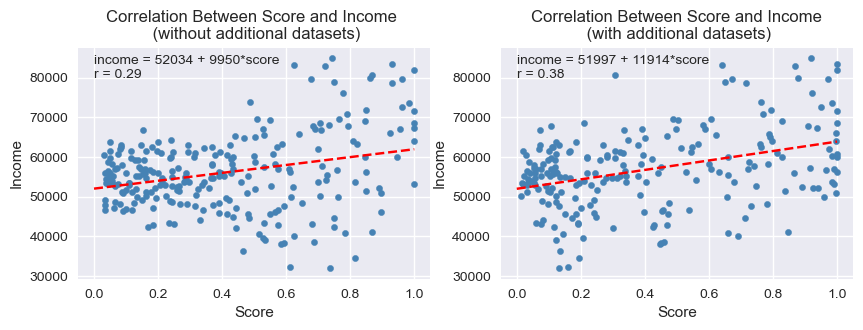

In [41]:
plt.style.use('seaborn')
f = plt.figure(figsize=(10,3))
f1 = f.add_subplot(121)
f2 = f.add_subplot(122)

a, b = np.polyfit(z_score["score"], z_score["median_income"], 1)
x = np.linspace(0, 1, 1000)
f1.scatter(z_score["score"], z_score["median_income"], color='steelblue', s = 20)
f1.plot(x, a*x+b, 'r', linestyle='--')
f1.text(0, 80000, 'income = {:.0f} + {:.0f}*'.format(b, a) + 'score\n', size=10)
f1.text(0, 80000, 'r = {:.2f}'.format(z_score.corr()["median_income"]["score"]), size=10)
f1.set_title("Correlation Between Score and Income \n (without additional datasets)" )
f1.set_xlabel("Score")
f1.set_ylabel("Income")

a, b = np.polyfit(z_score_full["score"], z_score_full["median_income"], 1)
f2.scatter(z_score_full["score"], z_score_full["median_income"], color='steelblue', s = 20)
f2.plot(x, a*x+b, 'r', linestyle='--')
f2.text(0, 80000, 'income = {:.0f} + {:.0f}*'.format(b, a) + 'score\n', size=10)
f2.text(0, 80000, 'r = {:.2f}'.format(z_score_full.corr()["median_income"]["score"]), size=10)
f2.set_title("Correlation Between Score and Income\n (with additional datasets)" )
f2.set_xlabel("Score")
f2.set_ylabel("Income")

#### Interactive Map

In [24]:
all_regions_data = gpd.GeoDataFrame.from_postgis("""
    SELECT ext_query_table.*, ext_scores.score
    FROM ext_query_table
    JOIN ext_scores USING (sa2_code)
""", conn)

unscored_regions = all_regions_data[all_regions_data["score"].isna()]
scored_regions = all_regions_data[all_regions_data["score"].notna()]

In [21]:
from bokeh.io import show
from bokeh.models import (ColorBar, GeoJSONDataSource, HoverTool, LinearColorMapper)
from bokeh.palettes import brewer
from bokeh.plotting import figure, output_file, save

scored_source = GeoJSONDataSource(geojson = scored_regions.to_json())
unscored_source = GeoJSONDataSource(geojson = unscored_regions.to_json())

palette = brewer['RdPu'][9][::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 1)
color_bar = ColorBar(color_mapper = color_mapper, 
                     orientation = 'horizontal',
                     title="Score")

score_map = figure(
    title = 'Extended Score Function by SA2 Region', 
    toolbar_location = 'above',
    tools = 'box_zoom, pan, wheel_zoom, reset')

scored_renderer = score_map.patches('xs','ys', 
                    source = scored_source,
                    fill_color = {'field': 'score',
                                 'transform': color_mapper},
                    line_color = 'black', 
                    line_width = 0.75)
unscored_renderer = score_map.patches('xs','ys', 
                    source = unscored_source,
                    fill_color = '#000000',
                    line_color = 'red',
                    line_width = 0.5,
                    fill_alpha=0.5)

score_map.add_tools(HoverTool(renderers = [scored_renderer, unscored_renderer],
                        tooltips = [('Region', '@sa2_name'),
                                    ('Score', '@score{0.000}'),
                                    ('Median Income', '@median_income{000,000}'),
                                    ('Population', '@total_people{000,000}'),
                                    ('Retail Businesses', '@n_retail'),
                                    ('Health Businesses', '@n_health'),
                                    ('Public Transport Stops', '@n_stops'),
                                    ('Election Polls', '@n_polls'),
                                    ('School Catchments', '@n_catchments'),
                                    ('Est. Homeless Population', '@homeless_persons'),
                                    ('Emergency Health Services', '@n_emergency'),
                                    ('Government Expenditure', '@expenditure{$000,000}')]))

score_map.add_layout(color_bar, 'below')

output_file(filename="sa2_score_map.html", title="Extended Score Function by SA2 Region Interactive Map")
save(score_map)
show(score_map)

#### Score Distribution

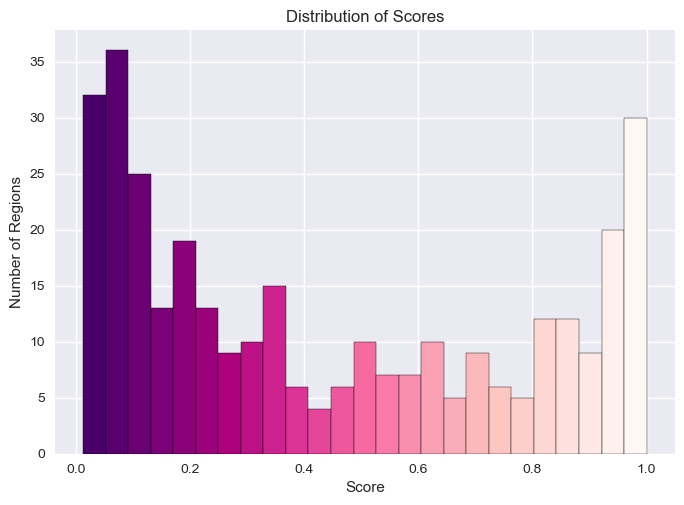

In [25]:
fig, ax = plt.subplots()

n, bins, patches = ax.hist(scored_regions["score"], 25, edgecolor="black")

bin_centers = 0.5 * (bins[:-1] + bins[1:])
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap('RdPu')
for c, p in zip(col[::-1], patches):
    plt.setp(p, 'facecolor', cm(c))

ax.set_title("Distribution of Scores")
ax.set_xlabel("Score")
ax.set_ylabel("Number of Regions")

fig.savefig("score_distribution.pdf")

# 6. Closing Connection

In [26]:
conn.close()